In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from google.colab import drive 

drive.mount('/content/drive')

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Mounted at /content/drive


In [2]:
data_dir =r"/content/drive/MyDrive/datasets_new_flipped/50-50/"
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=16,
    validation_split=0.2,
    seed=0,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8968 files belonging to 3 classes.
Using 7175 files for training.
Using 1793 files for validation.

label names: ['en' 'ja' 'pt']


In [3]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [4]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(16, 312192)
(16,)


In [5]:
label_names[[1,1,2,0]]


array(['ja', 'ja', 'pt', 'en'], dtype='<U2')

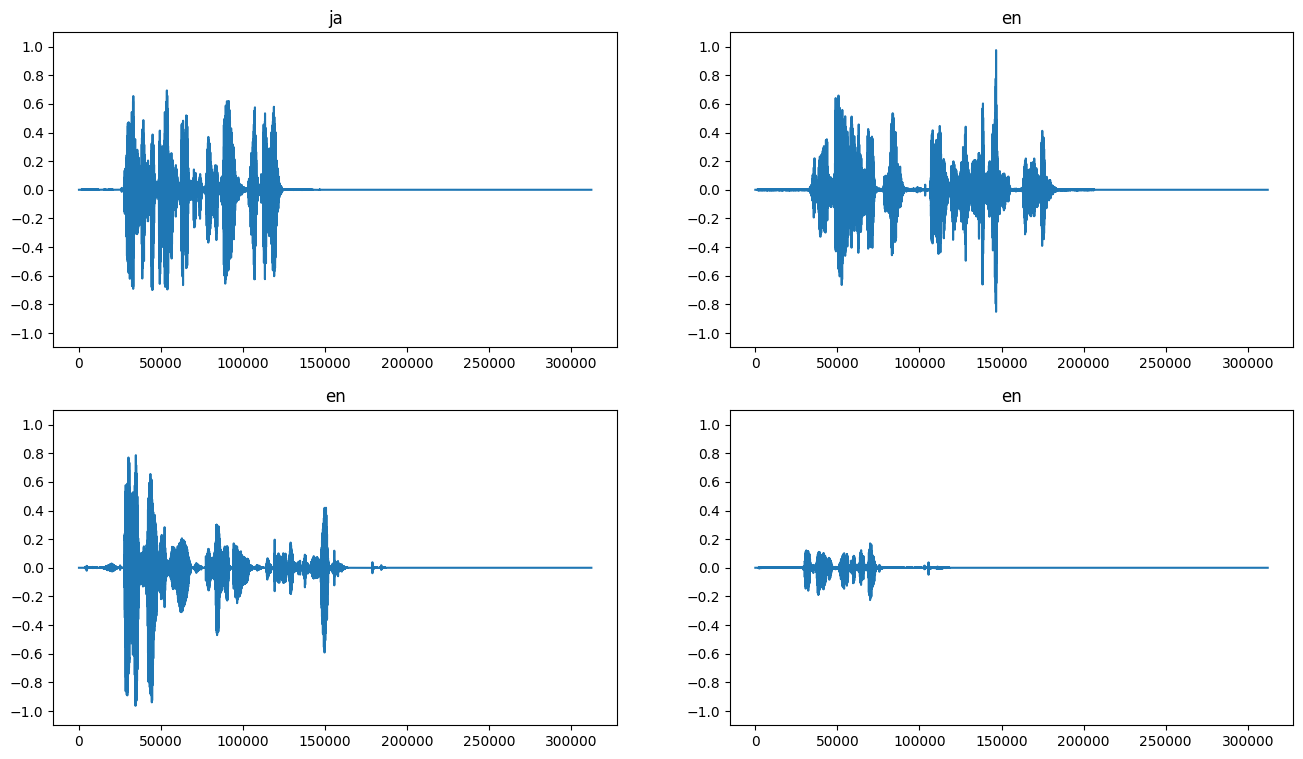

In [6]:
rows = 2
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [7]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [8]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Output hidden; open in https://colab.research.google.com to view.

In [9]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

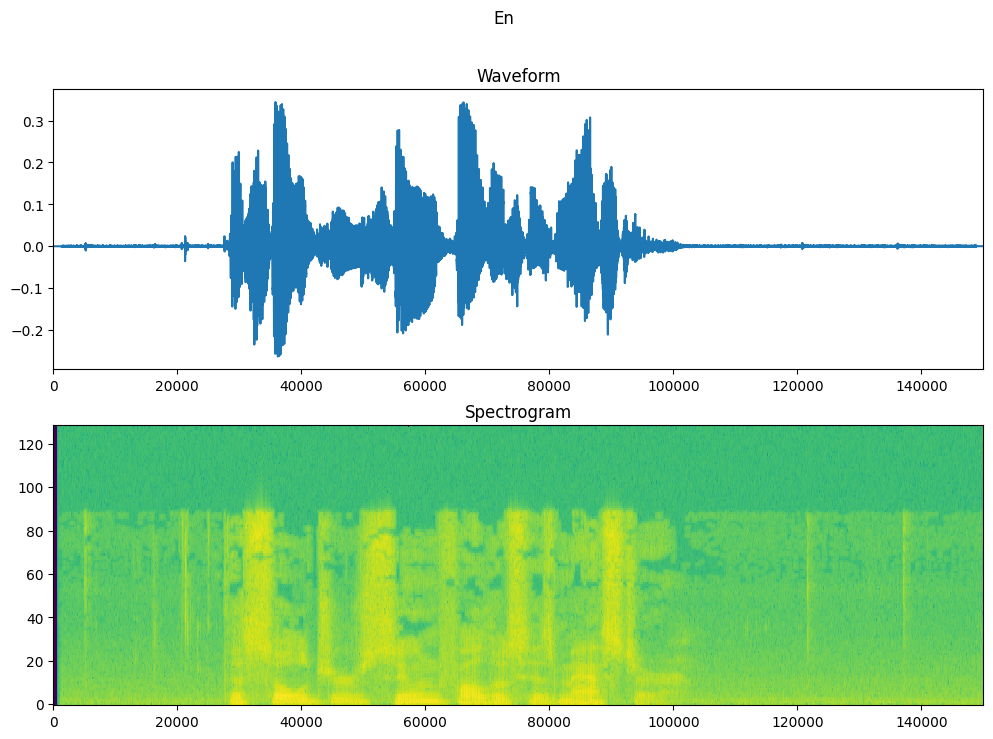

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')

# Set x-axis limits to the maximum x-value of the waveform plot
x_max = np.max(timescale)
axes[0].set_xlim([0, 150000])
axes[1].set_xlim([0, 150000])

plt.suptitle(label.title())
plt.show()


In [10]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [28]:
test = []

for example_spectrograms, example_spect_labels in train_spectrogram_ds:
  test.append(example_spectrograms)

In [29]:
for i in test:
  print(i.shape[1:])

(2312, 129, 1)
(2438, 129, 1)
(2510, 129, 1)
(2172, 129, 1)
(2888, 129, 1)
(2442, 129, 1)
(3050, 129, 1)
(2685, 129, 1)
(1943, 129, 1)
(2654, 129, 1)
(2492, 129, 1)
(2510, 129, 1)
(2843, 129, 1)
(2483, 129, 1)
(1979, 129, 1)
(2780, 129, 1)
(2793, 129, 1)
(2132, 129, 1)
(2186, 129, 1)
(2123, 129, 1)
(2510, 129, 1)
(1997, 129, 1)
(1808, 129, 1)
(2501, 129, 1)
(3185, 129, 1)
(2123, 129, 1)
(2555, 129, 1)
(2096, 129, 1)
(2654, 129, 1)
(2420, 129, 1)
(2195, 129, 1)
(2172, 129, 1)
(2307, 129, 1)
(2739, 129, 1)
(2096, 129, 1)
(2685, 129, 1)
(2681, 129, 1)
(2096, 129, 1)
(2132, 129, 1)
(2510, 129, 1)
(2145, 129, 1)
(2064, 129, 1)
(2258, 129, 1)
(2078, 129, 1)
(2366, 129, 1)
(2591, 129, 1)
(2708, 129, 1)
(2483, 129, 1)
(2577, 129, 1)
(2249, 129, 1)
(2969, 129, 1)
(2375, 129, 1)
(2469, 129, 1)
(1808, 129, 1)
(2258, 129, 1)
(1718, 129, 1)
(2091, 129, 1)
(1943, 129, 1)
(2555, 129, 1)
(2888, 129, 1)
(2321, 129, 1)
(1970, 129, 1)
(2501, 129, 1)
(2321, 129, 1)
(2897, 129, 1)
(2348, 129, 1)
(2735, 129

In [22]:
input_shape = example_spectrograms.shape[1:]
print(input_shape)

(2888, 129, 1)


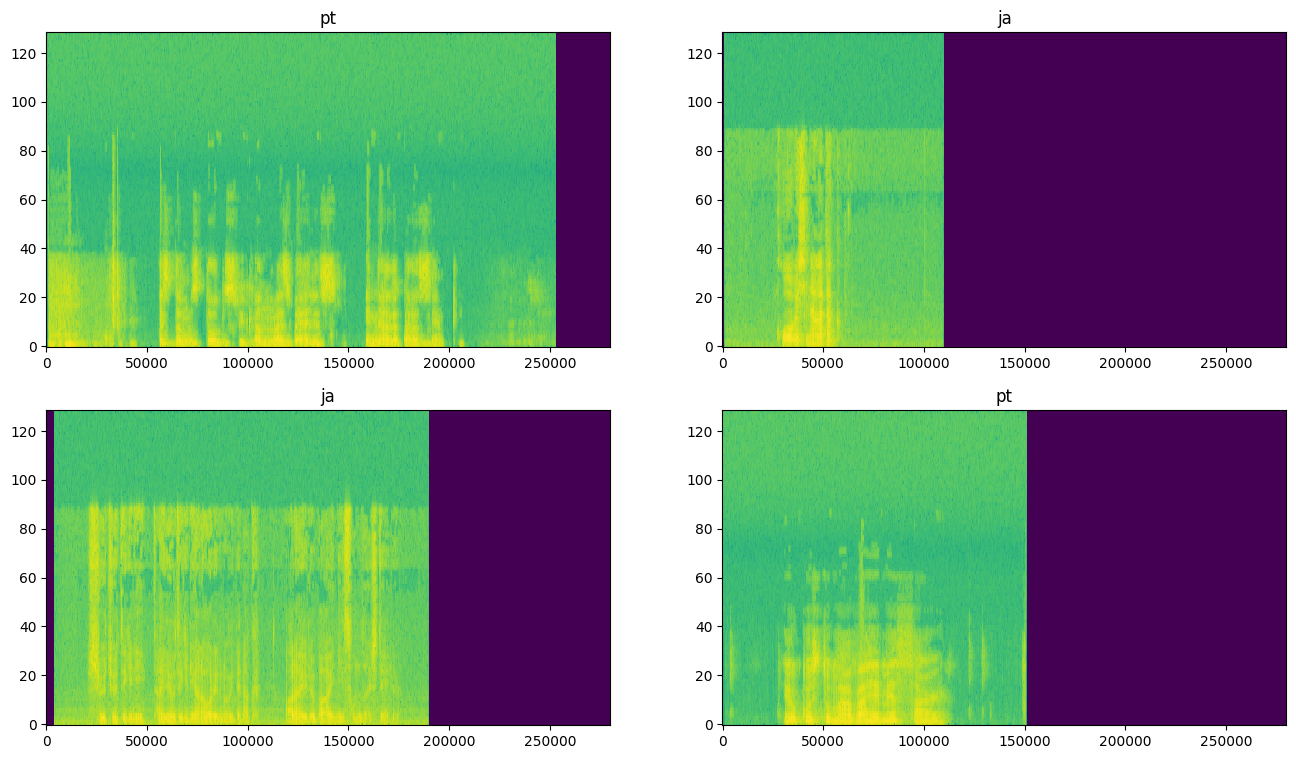

In [ ]:
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(3000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (2168, 129, 1)
